In [2]:
from hypersurface import *
import sympy as sp
from pprint import pprint
from scipy.optimize import minimize
from sympy.utilities.iterables import flatten
import math
import matplotlib.pyplot as plt
import itertools
from mpl_toolkits.mplot3d import Axes3D

In [3]:
z0, z1, z2, z3, z4= sp.symbols('z0, z1, z2, z3, z4')
Z = [z0,z1,z2,z3,z4]
f = z0**5 + z1**5 + z2**5 + z3**5 + z4**5 + 0.5*z0*z1*z2*z3*z4
HS = Hypersurface(Z, f, 1000)

In [4]:
k = 3
HS.set_k(k)

Normalization factor of eta

In [5]:
# holomorphic=True by default
factor = (HS.integrate(lambda patch, point: patch.omega_omegabar(point), numerical=True) / \
          HS.integrate(lambda patch, point: patch.num_FS_volume_form('identity', point), numerical=True))

In [6]:
def get_h_matrix(HS, k):
    # Get the power of the coordinates
    sec, ns = HS.get_sections(k)
    h_diag = []
    for expr in sec:
        power = []
        for i in range(len(Z)):
            power.append(expr.diff(Z[i])*Z[i]/expr)
        h_diag.append(power)

    h_matrix = []
    h_params = np.zeros((ns, ns))
    # make a pair for each matrix element
    for i in range(len(h_diag)):
        h_matrix_row = []
        pz = h_diag[i]
        for j in range(len(h_diag)):
            pzbar = h_diag[j]
            for l in range(len(Z)-1):
                if (pz[l]-pzbar[l]-pz[l+1]+pzbar[l+1]) % 5 != 0:
                    h_matrix_row.append([])
                    break
            else:
                h_matrix_row.append([pz,pzbar])
                h_params[i][j] = -1
                #if (pz!=pzbar):
                    #print( "non-diagonal", pz, pzbar )
        h_matrix.append(h_matrix_row)                  
    #print( h_matrix[2][2] )
    
    param = 1
    #h_params  = [0 for p in h_matrix]
    # w and v are the indices of the element in 1-D array h_matrix
    w, v = 0, 0
    for i in range(ns):
        for j in range(ns):
            if h_params[i][j] > -1:
                continue
            for m in range(i, ns):
                for n in range(ns):
                    if h_params[m][n] > -1:
                        continue
                    if sorted(h_matrix[m][n][0]) == sorted(h_matrix[i][j][0]):
                        for perm in itertools.permutations(range(5)):
                            if h_matrix[i][j] == [[h_matrix[m][n][0][p] for p in perm],[h_matrix[m][n][1][p] for p in perm]]:
                                h_params[m][n] = param
                                h_params[n][m] = param
                                break
            param += 1
            
    return h_params

In [7]:
h_sym = get_h_matrix(HS, k)

Reconstruct h matrix from the parameters

In [8]:
def param_to_matrix(param):
    h_matrix = h_sym.copy()
    for i in range(len(param)):
        for m in range(len(h_sym)):
            for n in range(len(h_sym)):
                if h_sym[m][n] == i+2:
                    h_matrix[m][n] = param[i]
    return h_matrix

In [9]:
def integration(param): 
    h = param_to_matrix(param)
    #h = np.matmul(g, np.conj(g.transpose()))
    integration = HS.patches[0].integrate(lambda patch, point, h_matrix=h: 
                                np.absolute(patch.num_eta(h_matrix, point)*factor - 1).real, 
                                holomorphic=False, numerical=True)
    integration = integration.real
    print(integration)
    print(param)
    try:
        np.linalg.cholesky(h)
    except:
        print("Not positive definite")
    return integration

Set an initial condition

In [10]:
g0 = k * np.ones(np.amax(h_sym.astype(int)) - 1)

In [11]:
#res = minimize(integration, g0, method='L-BFGS-B', options={'iprint':1, 'ftol': 1e-04, 'eps': 1e-02, 'maxiter':20})
res = minimize(integration, g0, method='L-BFGS-B', options={'ftol': 1e-06, 'maxiter':200})

0.4542823859863553
[3. 3.]
0.4542823856674049
[3.00000001 3.        ]
0.454282386862373
[3.         3.00000001]
0.3729240169968796
[3.34212054 2.06034393]
0.3729240169454635
[3.34212055 2.06034393]
0.3729240177246876
[3.34212054 2.06034394]
0.9085648733733983
[ 3.09754205 -3.11416694]
Not positive definite
0.9085648691888373
[ 3.09754206 -3.11416694]
Not positive definite
0.9085648693331825
[ 3.09754205 -3.11416693]
Not positive definite
0.28369116263863153
[3.2750495  0.64133177]
0.28369116282878354
[3.27504951 0.64133177]
0.28369116308777087
[3.2750495  0.64133178]
1.2673389608902519
[ 2.1460727  -2.67017338]
Not positive definite
1.2673389509234059
[ 2.14607271 -2.67017338]
Not positive definite
1.2673389527628867
[ 2.1460727  -2.67017337]
Not positive definite
0.2643266162024936
[ 3.05526041 -0.00335172]
Not positive definite
0.26432661630749427
[ 3.05526042 -0.00335172]
Not positive definite
0.26432661605327745
[ 3.05526041 -0.00335171]
Not positive definite
0.2624744771604132
[2.

In [12]:
h_minimal = param_to_matrix(res.x)

In [13]:
print(h_minimal)

[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.64027725 0.         ... 0.         0.         0.        ]
 [0.         0.         0.64027725 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.64027725 0.         0.        ]
 [0.         0.         0.         ... 0.         0.64027725 0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


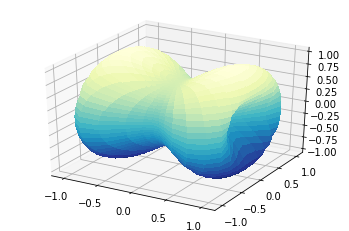

In [14]:
#param = [0.5, 0.5, 0.5, 0.5]
#h_minimal = param_to_matrix(param)
patch = HS.patches[0].patches[0]
theta, phi = np.linspace(0.001,np.pi+0.001, 40), np.linspace(0.001, 2*np.pi+0.001, 40)
R = []
for j in phi:
    theta_list = []
    for i in theta:
        t = complex(math.sin(i)*math.sin(j), math.cos(i))/(sin(i)*cos(j)) 
        if np.absolute(t) <= 1:
            eta = patch.num_eta(h_minimal, [1, -1, complex(t), 0, -complex(t)])*factor
        else:
            eta = patch.num_eta(h_minimal, [1, -1, complex(1/t), 0, -complex(1/t)])*factor
        theta_list.append(float(eta))
    R.append(theta_list)
R = np.asarray(R)
THETA, PHI = np.meshgrid(theta, phi)
X = R * np.sin(THETA) * np.cos(PHI)
Y = R * np.sin(THETA) * np.sin(PHI)
ZZ = R * np.cos(THETA)
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
plot = ax.plot_surface(
    X, Y, ZZ, rstride=1, cstride=1, cmap=plt.cm.YlGnBu_r,
    linewidth=0, antialiased=False)

Standard deviation of eta:

In [15]:
sum_eta = 0
for patch in HS.patches:
    for subpatch in patch.patches:
        for point in subpatch.points:
            #print(subpatch.num_eta(h_minimal, point)*factor - 1)
            sum_eta += (subpatch.num_eta(h_minimal, point)*factor - 1)**2
print(math.sqrt(sum_eta/(HS.n_points - 1)))

0.3236233235281381
